### Introduction

This notebooks demonestrates an image segmentation using the resnet50 with fully connected layers. <br>
Reference the materials listed below for further infromation about the methodology.

paper: https://arxiv.org/pdf/1611.08986.pdf  <br>
blog: https://www.azavea.com/blog/2017/05/30/deep-learning-on-aerial-imagery/  <br>
example: https://github.com/jpao10/CS230-Project/blob/master/resnet_notebook.ipynb 

#### Load packages and modules

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.models import Model
from keras.layers import (Input, Activation, Reshape, Conv2D, Lambda, Add)
import tensorflow as tf
import tensorflow as tf

/Users/adbe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Load Data

In [2]:
data = np.load('./segmentation_dir/data.npz')

x_train= data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']


x_train.shape, y_train.shape

((102, 256, 256, 3), (102, 256, 256, 1))

### Import Resnet50

In [3]:
from keras.applications.resnet50 import ResNet50

### Load layers convert to FCN

In [6]:
#base_model.summary()

In [7]:
def make_fcn_resnet(input_shape, nb_labels, use_pretraining, freeze_base):
    nb_rows, nb_cols, _ = input_shape
    input_tensor = Input(shape=input_shape)
    weights = 'imagenet' if use_pretraining else None

    model = ResNet50(
        include_top=False, weights=weights, input_tensor=input_tensor)

    if freeze_base:
        for layer in model.layers:
            layer.trainable = False

    x32 = model.get_layer('activation_22').output # older examples call this act3d
    x16 = model.get_layer('activation_40').output #  >>    >>      >>   >>  act4f
    x8 = model.get_layer('activation_49').output # >>      >>      >>   >>  act5c

    c32 = Conv2D(nb_labels, (1, 1), name='conv_labels_32')(x32)
    c16 = Conv2D(nb_labels, (1, 1), name='conv_labels_16')(x16)
    c8 = Conv2D(nb_labels, (1, 1), name='conv_labels_8')(x8)

    def resize_bilinear(images):
        return tf.image.resize_bilinear(images, [nb_rows, nb_cols])

    r32 = Lambda(resize_bilinear, name='resize_labels_32')(c32)
    r16 = Lambda(resize_bilinear, name='resize_labels_16')(c16)
    r8 = Lambda(resize_bilinear, name='resize_labels_8')(c8)

    m = Add(name='merge_labels')([r32, r16, r8])

    x = Reshape((nb_rows * nb_cols, nb_labels))(m)
    x = Activation('sigmoid')(x)
    x = Reshape((nb_rows, nb_cols, nb_labels))(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [8]:
model = make_fcn_resnet([256, 256, 3], 1, use_pretraining=True, freeze_base=False)

/Users/adbe/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


#### Tune Paramaters

In [11]:
nb_labels = 1
nb_cols = x_train.shape[1]
nb_rows =x_train.shape[2]
nb_bands = x_train.shape[3]

input_tensor = Input((nb_rows, nb_cols, nb_bands))

learning_rate = 0.001
optimizer = Adam(lr=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


#### Fit the model

In [12]:
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=25)

Train on 91 samples, validate on 11 samples
Epoch 1/25
91/91 [==============================] - 82s 901ms/step - loss: 0.4598 - acc: 0.8660 - val_loss: 0.5266 - val_acc: 0.9673
Epoch 2/25
91/91 [==============================] - 72s 795ms/step - loss: 0.3045 - acc: 0.9422 - val_loss: 0.5011 - val_acc: 0.9667
Epoch 3/25
91/91 [==============================] - 71s 775ms/step - loss: 0.2606 - acc: 0.9448 - val_loss: 0.3741 - val_acc: 0.9417
Epoch 4/25
91/91 [==============================] - 71s 777ms/step - loss: 0.2428 - acc: 0.9455 - val_loss: 0.6845 - val_acc: 0.7988
Epoch 5/25
91/91 [==============================] - 293s 3s/step - loss: 0.2121 - acc: 0.9465 - val_loss: 0.3679 - val_acc: 0.9030
Epoch 6/25
91/91 [==============================] - 96s 1s/step - loss: 0.1741 - acc: 0.9488 - val_loss: 0.2028 - val_acc: 0.9364
Epoch 7/25
91/91 [==============================] - 148s 2s/step - loss: 0.1621 - acc: 0.9512 - val_loss: 0.1330 - val_acc: 0.9671
Epoch 8/25
91/91 [==============

#### Examine

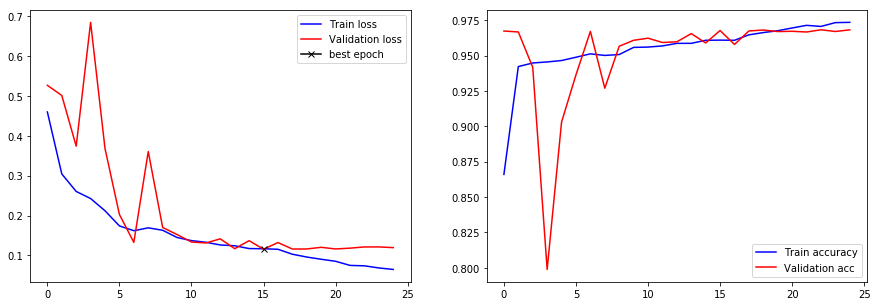

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(results.history['loss'], color='b', label="Train loss")
ax[0].plot(results.history['val_loss'], color='r',  label="Validation loss")

ax[0].plot(np.argmin(results.history["val_loss"]), 
         np.min(results.history["val_loss"]), 
         marker="x", color="#000000", label="best epoch")

ax[1].plot(results.history['acc'], color='b', label="Train accuracy")
ax[1].plot(results.history['val_acc'], color='r',label="Validation acc")
ax[0].legend()
ax[1].legend()
plt.show()

plt.show()

#### Predict

In [14]:
preds_test = model.predict(x_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

26/26 [==============================] - 8s 289ms/step


In [28]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    
    plt.subplot(141), plt.imshow(X[ix,])
    plt.title('Training Data')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142),plt.imshow(y[ix].squeeze())
    plt.title('Label Data')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(143),plt.imshow(preds[ix].squeeze())
    if has_mask:
        plt.contour(y[ix].squeeze(), colors='r', levels=[0.5])
    plt.title('Predicted output')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(144),plt.imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        plt.contour(y[ix].squeeze(), colors='r', levels=[0.5])
    plt.title('Predicted Binary output')
    plt.xticks([])
    plt.yticks([])

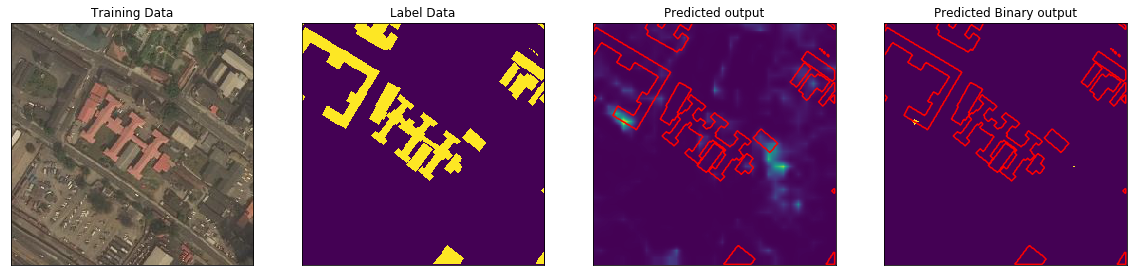

In [41]:
plot_sample(x_train, y_train, preds_test, preds_test_t, ix=(14))